In [1]:
import cv2 as cv
import numpy as np
import time
import matplotlib.pyplot as plt
import logging


In [2]:
class ImageStitcher:
    def __init__(self, smoothing_window_size=500):
        self.smoothing_window_size = smoothing_window_size
        self.detector = cv.SIFT_create()
        self.matcher = cv.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
        
        # Set up logging for debugging and analytics
        # logging.basicConfig(level=# # # # logging.debug, format='%(asctime)s - %(message)s')
        print("[INFO] Image Stitcher initialized.")
        
    def create_mask(self, img1, img2, version):
        """Creates a blending mask for smooth transition."""
        height_img1, width_img1 = img1.shape[:2]
        height_img2, width_img2 = img2.shape[:2]

        height_panorama = max(height_img1, height_img2)
        width_panorama = width_img1 + width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = width_img1 - offset

        mask = np.zeros((height_panorama, width_panorama))

        if version == 'left_image':
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(1, 0, 2 * offset).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(0, 1, 2 * offset).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1

        return cv.merge([mask, mask, mask])
    def calculate_distance_transform(self,image):
        """Calculate distance transform of the image."""
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        _, binary = cv.threshold(gray, 1, 255, cv.THRESH_BINARY)
        dist_transform = cv.distanceTransform(binary, cv.DIST_L2, 5)
        return dist_transform
    def weighted_blend(self, panorama1, panorama2):
        """Blend two panoramas using weighted average of overlapping regions."""
        print("[INFO] Performing weighted blending...")

        height, width = panorama1.shape[:2]
        
        # Step 1: Calculate distance transforms for both panoramas
        dist_transform1 = self.calculate_distance_transform(panorama1)
        dist_transform2 = self.calculate_distance_transform(panorama2)

        # Step 2: Initialize an empty result image
        result = np.zeros_like(panorama1)

        # Step 3: Loop over all pixels in the images
        for row in range(height):
            for col in range(width):
                pixel1 = panorama1[row, col]
                pixel2 = panorama2[row, col]

                # Get the distance transform values for the current pixel
                dist1 = dist_transform1[row, col]
                dist2 = dist_transform2[row, col]

                # Calculate the alpha value for weighted blending
                total_dist = dist1 + dist2
                alpha = dist1 / total_dist if total_dist != 0 else 0.5  # Handle divide by zero if no overlap

                # Apply the weighted blending formula
                result[row, col] = alpha * pixel1 + (1 - alpha) * pixel2
        return result

    def linear_blend(self, panorama1, panorama2, mask1, mask2):
        """Applies linear blending by gradually changing the contribution of each image."""
        # Define the blending region
        blended = np.zeros_like(panorama1)

        # Apply linear mask blending
        for y in range(panorama1.shape[0]):
            for x in range(panorama1.shape[1]):
                # Calculate the mask value based on x position (horizontal blending)
                alpha = (x - mask1.shape[1] // 2) / (mask1.shape[1] // 2)  # Change this for more control over blending

                # Clip alpha to ensure it's within valid range [0, 1]
                alpha = np.clip(alpha, 0, 1)

                # Linearly blend pixels based on alpha
                blended[y, x] = panorama1[y, x] * (1 - alpha) + panorama2[y, x] * alpha

        return blended

    def blending(self, H, img1, img2):
        """Applies linear blending after warping img2 onto img1."""
        print("[INFO] Blending images...")
        height_img1, width_img1 = img1.shape[:2]
        height_img2, width_img2 = img2.shape[:2]

        height_panorama = max(height_img1, height_img2)
        width_panorama = width_img1 + width_img2 
        print("[INFO] Height and Width of Panorama: ", height_panorama, width_panorama)

        # Creating the panorama space
        panorama1 = np.zeros((height_panorama, width_panorama, 3))

        # Create blending masks
        mask1 = self.create_mask(img1, img2, version='left_image')
        mask2 = self.create_mask(img1, img2, version='right_image')

        # Place first image
        panorama1[:height_img1, :width_img1, :] = img1
        # panorama1 *= mask1

        # Warp second image using homography
        # panorama2 = cv.warpPerspective(img2, H, (width_panorama, height_panorama)) * mask2
        panorama2 = cv.warpPerspective(img2, H, (width_panorama, height_panorama)) 



        # Linear Blend images
        # result = panorama1 + panorama2
        
        # Weighted blending
        # Save panorama1 and panorama2 for debugging
        panorama1 = np.uint8(panorama1)
        panorama2 = np.uint8(panorama2)
        plt.imsave("panorama1.jpg", cv.cvtColor(panorama1, cv.COLOR_BGR2RGB))
        plt.imsave("panorama2.jpg", cv.cvtColor(panorama2, cv.COLOR_BGR2RGB))
        print("[INFO] Panorama1 and Panorama2 saved.")

        start_time = time.time()
        result = self.weighted_blend(panorama1, panorama2)
        end_time = time.time()
        print(f"[INFO] Weighted blending completed in {end_time - start_time:.4f} seconds.")        

        # Crop black areas
        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]

        print("[INFO] Blending completed.")
        return final_result, panorama1, panorama2
    def match_histograms(self, img1, img2):
        img1_yuv = cv.cvtColor(img1, cv.COLOR_BGR2YUV)
        img2_yuv = cv.cvtColor(img2, cv.COLOR_BGR2YUV)

        img1_yuv[:,:,0] = cv.equalizeHist(img1_yuv[:,:,0])
        img2_yuv[:,:,0] = cv.equalizeHist(img2_yuv[:,:,0])

        return cv.cvtColor(img1_yuv, cv.COLOR_YUV2BGR), cv.cvtColor(img2_yuv, cv.COLOR_YUV2BGR)
    def stitch_images(self, img1, img2):
        """Stitches two images using SIFT for feature detection."""
        print("[INFO] Stitching images using SIFT...")
        img1, img2 = self.match_histograms(img1, img2)
        gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

        start_time = time.time()

        # Feature detection
        keypoints1, descriptors1 = self.detector.detectAndCompute(gray1, None)
        keypoints2, descriptors2 = self.detector.detectAndCompute(gray2, None)

        # Feature matching
        matches = self.matcher.knnMatch(descriptors1, descriptors2, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

        # logging.debug(f"SIFT - Matches Found: {len(good_matches)}")

        if len(good_matches) < 4:
            raise ValueError("Not enough good matches found! (matches found < 4)")

        # Homography estimation
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, status = cv.findHomography(dst_pts, src_pts, cv.RANSAC, 5.0)

        # Homography status analysis
        num_inliers = np.sum(status)
        num_outliers = len(status) - num_inliers
        # logging.debug(f"Homography estimation: Inliers = {num_inliers}, Outliers = {num_outliers}")
        print(f"[INFO] Homography estimation: Inliers = {num_inliers}, Outliers = {num_outliers}")
        # Apply blending
        result, mask1, mask2 = self.blending(H, img1, img2)


        end_time = time.time()
        execution_time = end_time - start_time
        # logging.debug(f"SIFT - Execution Time: {execution_time:.4f} seconds")
        print(f"[INFO] SIFT - Execution Time: {execution_time:.4f} seconds")
        return result, mask1, mask2, keypoints1, keypoints2, good_matches, execution_time, H

    def plot_feature_matching(self, img1, img2, keypoints1, keypoints2, good_matches):
        """Plots feature matching between two images."""
        img_matches = cv.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(15, 10))
        plt.imshow(img_matches)
        plt.title("Feature Matching")
        plt.show()

    def plot_keypoints(self, img, keypoints):
        """Plot keypoints detected in an image."""
        img_keypoints = cv.drawKeypoints(img, keypoints, None, color=(0, 255, 0), flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
        plt.figure(figsize=(10, 7))
        plt.imshow(img_keypoints)
        plt.title("Detected Keypoints")
        plt.show()

    def analyze_matches(self, good_matches, keypoints1, keypoints2):
        """Analysis of matches between keypoints."""
        match_distances = [m.distance for m in good_matches]
        avg_distance = np.mean(match_distances)
        max_distance = np.max(match_distances)
        min_distance = np.min(match_distances)

        # logging.debug(f"Match analysis: Avg distance = {avg_distance:.4f}, Max distance = {max_distance:.4f}, Min distance = {min_distance:.4f}")

        return avg_distance, max_distance, min_distance

[INFO] Image Stitcher initialized.
[INFO] Stitching images using SIFT...
[INFO] Homography estimation: Inliers = 181, Outliers = 326
[INFO] Blending images...
[INFO] Height and Width of Panorama:  3000 8000
[INFO] Panorama1 and Panorama2 saved.
[INFO] Performing weighted blending...
[INFO] Weighted blending completed in 518.3110 seconds.
[INFO] Blending completed.
[INFO] SIFT - Execution Time: 564.4222 seconds


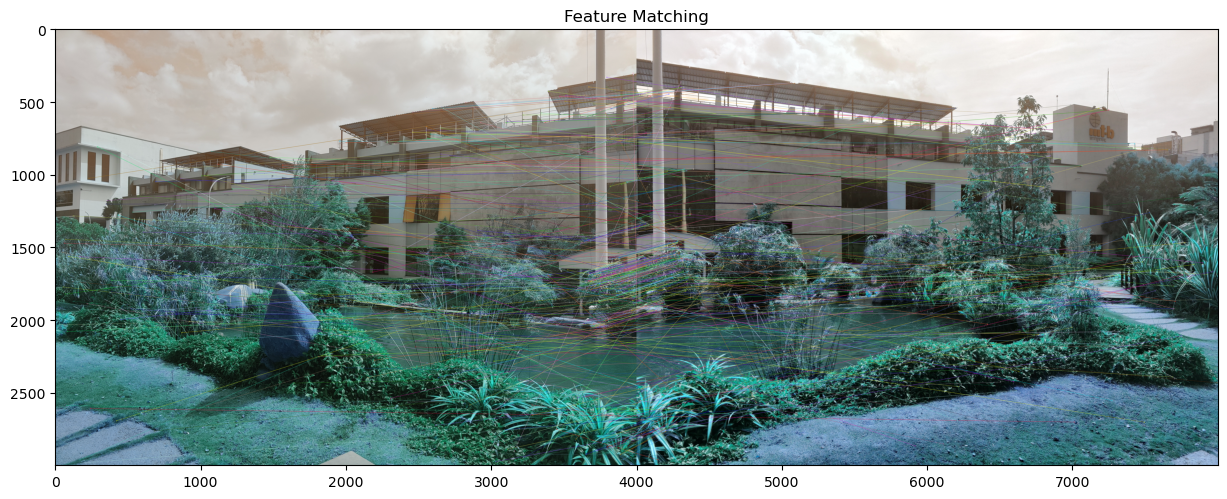

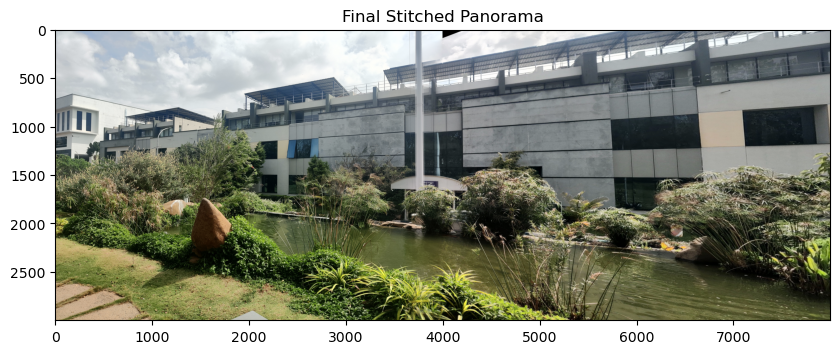

In [3]:
# Load images
base_path = './OpenCV Stitching Tutorial/imgs/'
# image_files = ['weir_1.jpg', 'weir_2.jpg', 'weir_3.jpg']  # List of image file names
image_files = ['IIITB1.jpeg', 'IIITB2.jpeg']
# image_files = ['budapest1.jpg', 'budapest2.jpg', 'budapest3.jpg', 'budapest4.jpg', 'budapest5.jpg', 'budapest6.jpg']  # List of image file names

# Read images
images = [cv.imread(base_path+file) for file in image_files]

# Check if all images are loaded successfully
if any(img is None for img in images):
    raise FileNotFoundError("Error: One or more images could not be loaded!")

# Initialize the ImageStitcher
stitcher = ImageStitcher()

# Start with the first image
panorama = images[0]

# Initialize keypoints and descriptors for stitching
keypoints_all = []
descriptors_all = []

# Iterate through the images and stitch them together
for i in range(1, len(images)):
    img1 = panorama
    img2 = images[i]
    
    # Stitch the two images together
    stitched_image, mask1, mask2, keypoints1, keypoints2, good_matches, execution_time, H = stitcher.stitch_images(img1, img2)
    
    # Save images with detected SIFT keypoints
    img1_keypoints = cv.drawKeypoints(img1, keypoints1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_keypoints = cv.drawKeypoints(img2, keypoints2, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    cv.imwrite(f"keypoints_image_{i-1}.jpg", img1_keypoints)
    cv.imwrite(f"keypoints_image_{i}.jpg", img2_keypoints)
    # Log execution time and homography
    # logging.debug(f"Execution Time: {execution_time:.4f} seconds")
    # logging.debug(f"Homography Matrix: \n{H}")
    
    # Plot feature matching for debugging
    stitcher.plot_feature_matching(img1, img2, keypoints1, keypoints2, good_matches)
    
    # Update panorama for the next iteration
    panorama = stitched_image

# Final stitched panorama
plt.figure(figsize=(10, 7))
plt.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))
plt.title("Final Stitched Panorama")
plt.show()


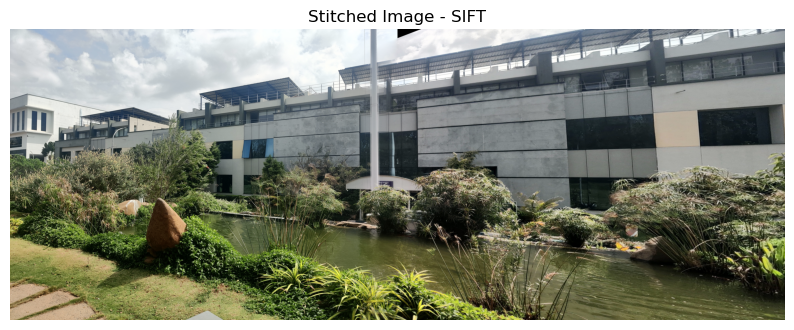

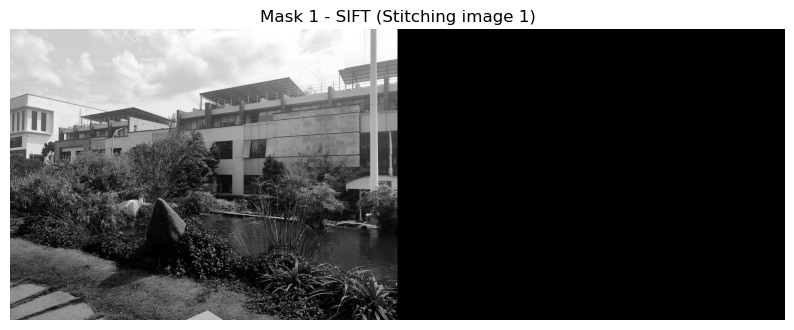

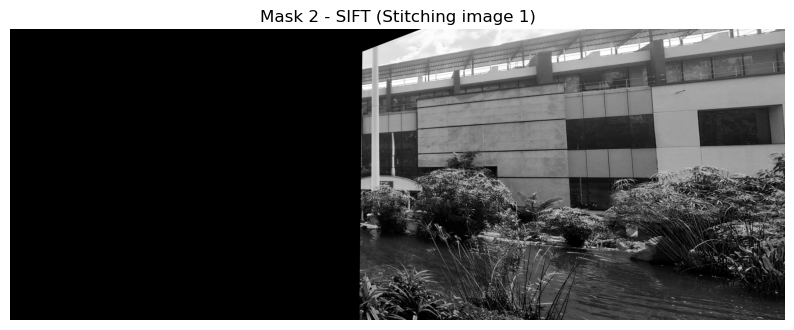

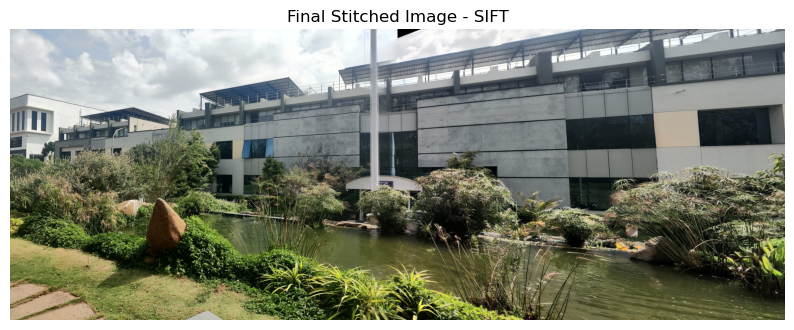

In [4]:
# After the stitching loop, plot the final stitched image
plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.title("Stitched Image - SIFT")
plt.axis('off')  # Turn off axis
plt.show()

# Optional: Plot the masks after each image stitching (if you want to visualize the masks for each step)
for i in range(1, len(images)):
    # Plot Mask 1 - SIFT for the current pair
    plt.figure(figsize=(10, 8))
    plt.imshow(mask1[:, :, 0], cmap='gray')  # Display only one channel (as mask is grayscale)
    plt.title(f"Mask 1 - SIFT (Stitching image {i})")
    plt.axis('off')  # Turn off axis
    plt.show()

    # Plot Mask 2 - SIFT for the current pair
    plt.figure(figsize=(10, 8))
    plt.imshow(mask2[:, :, 0], cmap='gray')  # Display only one channel (as mask is grayscale)
    plt.title(f"Mask 2 - SIFT (Stitching image {i})")
    plt.axis('off')  # Turn off axis
    plt.show()

# Optional: Show the final stitched image after all iterations
plt.figure(figsize=(10, 8))
plt.imshow(cv.cvtColor(panorama, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.title("Final Stitched Image - SIFT")
plt.axis('off')  # Turn off axis
plt.show()

# Close any OpenCV windows (if needed)
cv.waitKey(0)
cv.destroyAllWindows()


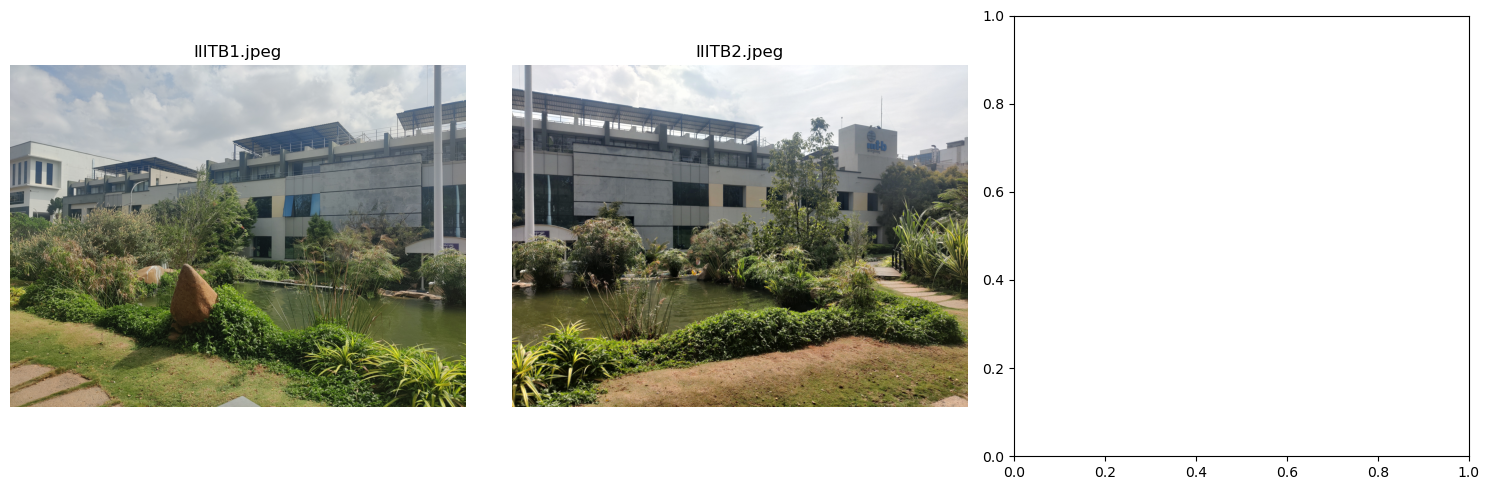

In [5]:
# Convert BGR to RGB for correct display in Matplotlib
images = [cv.cvtColor(img, cv.COLOR_BGR2RGB) for img in images]

# Create a 3x2 grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 2 rows, 3 columns

for ax, img, path in zip(axes.flatten(), images, image_files):
    ax.imshow(img)
    ax.set_title(path)  # Optional: Shows filename on top of each image
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.savefig("three_input_images.jpg", dpi=300)  # Save the final grid image
plt.show()